In [ ]:
# !cp "/content/drive/MyDrive/Thesis/Data/graph_ready_data.zip" graph_ready_data.zip
# !unzip graph_ready_data.zip

In [1]:
import os
import torch
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn import Linear
from tqdm import tqdm
from torch_geometric.nn import GCNConv, GraphConv, GATConv, CGConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx

/home/ura/miniconda3/envs/geometric/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
DATA_SIZE = 685 # Test 20000 sample cuoi
USING_SIZE = 685

In [46]:
class GraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_folder=None, is_train=True):
        self.data_folder = data_folder
        self.is_train = is_train
        self.graphs = []

        if os.path.exists(self.data_folder):
          self.list_graphs = os.listdir(self.data_folder)
          self.list_graphs = {int(y.split("_")[0]):y for y in filter(lambda x: x.endswith(".pkl"), self.list_graphs)}

          self.list_labels = pickle.load(open("labels.pkl", "rb"))
        
        if os.path.exists(root):
          print("Data exists")
          # self.processed_files = os.listdir(root + "/processed")
          # self.processed_files = list(filter(lambda x: x.endswith(".pt"), self.processed_files))
          self.processed_files = [f'data_{idx}.pt' for idx in range(DATA_SIZE)]
          if self.is_train:
            self.processed_files = self.processed_files[:USING_SIZE]
          else:
            self.processed_files = self.processed_files[int(DATA_SIZE*0.8):DATA_SIZE]

        else:
          self.processed_files = []

        super().__init__(root, transform, pre_transform, pre_filter)

        print("Loading data...")
        for pf in tqdm(self.processed_files):
          self.graphs.append(torch.load(os.path.join(self.processed_dir, pf)))

    @property
    def raw_file_names(self):
        return self.list_graphs

    @property
    def processed_file_names(self):
        return self.processed_files

    def process(self):
        for idx, raw_path in self.list_graphs.items():
            # Read data from `raw_path`.
            data = from_networkx(nx.read_gpickle(os.path.join(self.data_folder, raw_path)), group_node_attrs=["label"])
            data.x = torch.nn.functional.one_hot(data.x-1, 5).squeeze(1).type(torch.FloatTensor)
            data.y = torch.FloatTensor([self.list_labels[idx]])
            data.edge_index = data.edge_index.type(torch.LongTensor)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            self.graphs.append(data)
            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            self.processed_files.append(f'data_{idx}.pt')

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        # data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        data = self.graphs[idx-1]
        return data

In [47]:
def transform_func(graph):
  graph.x = graph.x.to("cuda:0")
  graph.y = graph.y.to("cuda:0")
  graph.edge_index = graph.edge_index.to("cuda:0")
  return graph

In [48]:
train_dataset = GraphDataset("ready_data", transform=transform_func, data_folder="data", is_train=True)
test_dataset = GraphDataset("ready_data", transform=transform_func, data_folder="data", is_train=False)

Data exists
Loading data...


100%|██████████| 685/685 [00:00<00:00, 4915.06it/s]


Data exists
Loading data...


100%|██████████| 137/137 [00:00<00:00, 6698.37it/s]


In [49]:
# Test
# g = train_dataset.get(0)
# g.x

In [50]:
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1024, shuffle = True)

In [51]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(5, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels, bias=True)
        self.lin2 = Linear(hidden_channels, hidden_channels, bias=True)
        self.lin3 = Linear(hidden_channels, 1, bias=True)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        # x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        x = torch.sigmoid(x) * 150
        
        return x

model = GNN(hidden_channels=64).to("cuda:0")
print(model)

GNN(
  (conv1): GraphConv(5, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (conv4): GraphConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)


In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    steps = 0

    for data in loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.view(-1, 1))  # Compute the loss.
         total_loss += loss
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         steps += 1

    return total_loss / steps

def test(loader):
     model.eval()
     mse = 0
     steps = 0
        
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         mse += F.mse_loss(out, data.y.view(-1, 1))  # Check against ground-truth labels.
         steps += 1
     return mse / steps  # Derive ratio of correct predictions.

min_mse = 1e10
min_epoch = 0

for epoch in tqdm(range(10000)):
    train_mse = train(train_loader)
    if (epoch+1) % 50 == 0:
        test_mse = test(test_loader)
        if test_mse < min_mse:
            min_mse = test_mse
            min_epoch = epoch
        print(f'Epoch: {epoch+1:03d}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Min MSE: {min_mse:.4f}, AtEpoch: {min_epoch}')
    else:
        test_mse = 0

  1%|          | 56/10000 [00:01<04:16, 38.74it/s]

Epoch: 050, Train MSE: 3.1501, Test MSE: 0.6479, Min MSE: 0.6479, AtEpoch: 49


  1%|          | 104/10000 [00:02<04:14, 38.83it/s]

Epoch: 100, Train MSE: 0.8090, Test MSE: 0.4785, Min MSE: 0.4785, AtEpoch: 99


  2%|▏         | 156/10000 [00:04<04:13, 38.82it/s]

Epoch: 150, Train MSE: 0.5328, Test MSE: 0.2954, Min MSE: 0.2954, AtEpoch: 149


  2%|▏         | 204/10000 [00:05<04:13, 38.67it/s]

Epoch: 200, Train MSE: 0.3986, Test MSE: 0.1876, Min MSE: 0.1876, AtEpoch: 199


  3%|▎         | 256/10000 [00:06<04:11, 38.68it/s]

Epoch: 250, Train MSE: 0.3182, Test MSE: 0.1423, Min MSE: 0.1423, AtEpoch: 249


  3%|▎         | 304/10000 [00:07<04:09, 38.80it/s]

Epoch: 300, Train MSE: 0.2634, Test MSE: 0.1145, Min MSE: 0.1145, AtEpoch: 299


  4%|▎         | 356/10000 [00:09<04:08, 38.78it/s]

Epoch: 350, Train MSE: 0.2230, Test MSE: 0.0920, Min MSE: 0.0920, AtEpoch: 349


  4%|▍         | 404/10000 [00:10<04:08, 38.69it/s]

Epoch: 400, Train MSE: 1.1050, Test MSE: 1.3332, Min MSE: 0.0920, AtEpoch: 349


  5%|▍         | 456/10000 [00:11<04:07, 38.63it/s]

Epoch: 450, Train MSE: 0.2211, Test MSE: 0.1008, Min MSE: 0.0920, AtEpoch: 349


  5%|▌         | 504/10000 [00:12<04:04, 38.78it/s]

Epoch: 500, Train MSE: 2.0254, Test MSE: 0.0936, Min MSE: 0.0920, AtEpoch: 349


  6%|▌         | 556/10000 [00:14<04:03, 38.73it/s]

Epoch: 550, Train MSE: 0.1517, Test MSE: 0.0653, Min MSE: 0.0653, AtEpoch: 549


  6%|▌         | 604/10000 [00:15<04:26, 35.26it/s]

Epoch: 600, Train MSE: 0.1791, Test MSE: 0.1115, Min MSE: 0.0653, AtEpoch: 549


  7%|▋         | 656/10000 [00:16<04:02, 38.53it/s]

Epoch: 650, Train MSE: 4.6570, Test MSE: 0.3979, Min MSE: 0.0653, AtEpoch: 549


  7%|▋         | 704/10000 [00:18<04:00, 38.58it/s]

Epoch: 700, Train MSE: 0.2092, Test MSE: 0.1262, Min MSE: 0.0653, AtEpoch: 549


  8%|▊         | 756/10000 [00:19<03:59, 38.58it/s]

Epoch: 750, Train MSE: 0.1209, Test MSE: 0.0462, Min MSE: 0.0462, AtEpoch: 749


  8%|▊         | 804/10000 [00:20<04:01, 38.07it/s]

Epoch: 800, Train MSE: 0.1007, Test MSE: 0.0379, Min MSE: 0.0379, AtEpoch: 799


  9%|▊         | 856/10000 [00:22<03:57, 38.57it/s]

Epoch: 850, Train MSE: 0.0887, Test MSE: 0.0327, Min MSE: 0.0327, AtEpoch: 849


  9%|▉         | 904/10000 [00:23<03:55, 38.66it/s]

Epoch: 900, Train MSE: 0.0943, Test MSE: 0.0422, Min MSE: 0.0327, AtEpoch: 849


 10%|▉         | 956/10000 [00:24<03:56, 38.20it/s]

Epoch: 950, Train MSE: 0.0916, Test MSE: 0.0339, Min MSE: 0.0327, AtEpoch: 849


 10%|█         | 1004/10000 [00:25<03:53, 38.58it/s]

Epoch: 1000, Train MSE: 0.2243, Test MSE: 0.1678, Min MSE: 0.0327, AtEpoch: 849


 11%|█         | 1056/10000 [00:27<03:52, 38.54it/s]

Epoch: 1050, Train MSE: 0.1361, Test MSE: 0.4576, Min MSE: 0.0327, AtEpoch: 849


 11%|█         | 1104/10000 [00:28<03:51, 38.38it/s]

Epoch: 1100, Train MSE: 0.0774, Test MSE: 0.0399, Min MSE: 0.0327, AtEpoch: 849


 12%|█▏        | 1156/10000 [00:29<03:49, 38.62it/s]

Epoch: 1150, Train MSE: 0.1224, Test MSE: 0.1174, Min MSE: 0.0327, AtEpoch: 849


 12%|█▏        | 1204/10000 [00:31<03:48, 38.43it/s]

Epoch: 1200, Train MSE: 0.1618, Test MSE: 0.0772, Min MSE: 0.0327, AtEpoch: 849


 13%|█▎        | 1256/10000 [00:32<03:56, 36.98it/s]

Epoch: 1250, Train MSE: 0.0800, Test MSE: 0.0491, Min MSE: 0.0327, AtEpoch: 849


 13%|█▎        | 1304/10000 [00:33<03:44, 38.68it/s]

Epoch: 1300, Train MSE: 0.1650, Test MSE: 0.1215, Min MSE: 0.0327, AtEpoch: 849


 14%|█▎        | 1356/10000 [00:34<03:43, 38.62it/s]

Epoch: 1350, Train MSE: 0.1880, Test MSE: 0.2205, Min MSE: 0.0327, AtEpoch: 849


 14%|█▍        | 1404/10000 [00:36<03:42, 38.65it/s]

Epoch: 1400, Train MSE: 0.0611, Test MSE: 0.0249, Min MSE: 0.0249, AtEpoch: 1399


 15%|█▍        | 1456/10000 [00:37<03:41, 38.63it/s]

Epoch: 1450, Train MSE: 0.3099, Test MSE: 0.1440, Min MSE: 0.0249, AtEpoch: 1399


 15%|█▌        | 1504/10000 [00:38<03:40, 38.56it/s]

Epoch: 1500, Train MSE: 0.3837, Test MSE: 0.0314, Min MSE: 0.0249, AtEpoch: 1399


 16%|█▌        | 1556/10000 [00:40<03:39, 38.55it/s]

Epoch: 1550, Train MSE: 0.2115, Test MSE: 0.1753, Min MSE: 0.0249, AtEpoch: 1399


 16%|█▌        | 1604/10000 [00:41<03:38, 38.36it/s]

Epoch: 1600, Train MSE: 0.3964, Test MSE: 0.1929, Min MSE: 0.0249, AtEpoch: 1399


 17%|█▋        | 1656/10000 [00:42<03:35, 38.65it/s]

Epoch: 1650, Train MSE: 0.9073, Test MSE: 0.6614, Min MSE: 0.0249, AtEpoch: 1399


 17%|█▋        | 1704/10000 [00:43<03:34, 38.71it/s]

Epoch: 1700, Train MSE: 0.0592, Test MSE: 0.0322, Min MSE: 0.0249, AtEpoch: 1399


 18%|█▊        | 1756/10000 [00:45<03:33, 38.66it/s]

Epoch: 1750, Train MSE: 0.0427, Test MSE: 0.0197, Min MSE: 0.0197, AtEpoch: 1749


 18%|█▊        | 1804/10000 [00:46<03:32, 38.66it/s]

Epoch: 1800, Train MSE: 0.0388, Test MSE: 0.0190, Min MSE: 0.0190, AtEpoch: 1799


 19%|█▊        | 1856/10000 [00:47<03:30, 38.63it/s]

Epoch: 1850, Train MSE: 0.1152, Test MSE: 0.0636, Min MSE: 0.0190, AtEpoch: 1799


 19%|█▉        | 1904/10000 [00:49<03:31, 38.31it/s]

Epoch: 1900, Train MSE: 0.0883, Test MSE: 0.0693, Min MSE: 0.0190, AtEpoch: 1799


 20%|█▉        | 1956/10000 [00:50<03:29, 38.46it/s]

Epoch: 1950, Train MSE: 0.0395, Test MSE: 0.0223, Min MSE: 0.0190, AtEpoch: 1799


 20%|██        | 2004/10000 [00:51<03:27, 38.59it/s]

Epoch: 2000, Train MSE: 0.1279, Test MSE: 0.0572, Min MSE: 0.0190, AtEpoch: 1799


 21%|██        | 2056/10000 [00:53<03:24, 38.79it/s]

Epoch: 2050, Train MSE: 1.3572, Test MSE: 1.4602, Min MSE: 0.0190, AtEpoch: 1799


 21%|██        | 2104/10000 [00:54<03:23, 38.75it/s]

Epoch: 2100, Train MSE: 0.0409, Test MSE: 0.0260, Min MSE: 0.0190, AtEpoch: 1799


 22%|██▏       | 2156/10000 [00:55<03:22, 38.73it/s]

Epoch: 2150, Train MSE: 0.0394, Test MSE: 0.0259, Min MSE: 0.0190, AtEpoch: 1799


 22%|██▏       | 2204/10000 [00:56<03:30, 37.03it/s]

Epoch: 2200, Train MSE: 0.0458, Test MSE: 0.0325, Min MSE: 0.0190, AtEpoch: 1799


 23%|██▎       | 2256/10000 [00:58<03:20, 38.67it/s]

Epoch: 2250, Train MSE: 0.0401, Test MSE: 0.0166, Min MSE: 0.0166, AtEpoch: 2249


 23%|██▎       | 2304/10000 [00:59<03:18, 38.76it/s]

Epoch: 2300, Train MSE: 2.1125, Test MSE: 0.3752, Min MSE: 0.0166, AtEpoch: 2249


 24%|██▎       | 2356/10000 [01:00<03:17, 38.71it/s]

Epoch: 2350, Train MSE: 0.0622, Test MSE: 0.0282, Min MSE: 0.0166, AtEpoch: 2249


 24%|██▍       | 2404/10000 [01:01<03:15, 38.77it/s]

Epoch: 2400, Train MSE: 0.0394, Test MSE: 0.0186, Min MSE: 0.0166, AtEpoch: 2249


 25%|██▍       | 2456/10000 [01:03<03:14, 38.81it/s]

Epoch: 2450, Train MSE: 0.0327, Test MSE: 0.0155, Min MSE: 0.0155, AtEpoch: 2449


 25%|██▌       | 2504/10000 [01:04<03:13, 38.80it/s]

Epoch: 2500, Train MSE: 0.0290, Test MSE: 0.0140, Min MSE: 0.0140, AtEpoch: 2499


 26%|██▌       | 2556/10000 [01:05<03:11, 38.80it/s]

Epoch: 2550, Train MSE: 0.0345, Test MSE: 0.0393, Min MSE: 0.0140, AtEpoch: 2499


 26%|██▌       | 2604/10000 [01:07<03:10, 38.85it/s]

Epoch: 2600, Train MSE: 0.0437, Test MSE: 0.0312, Min MSE: 0.0140, AtEpoch: 2499


 27%|██▋       | 2656/10000 [01:08<03:09, 38.68it/s]

Epoch: 2650, Train MSE: 0.0874, Test MSE: 0.0314, Min MSE: 0.0140, AtEpoch: 2499


 27%|██▋       | 2704/10000 [01:09<03:08, 38.78it/s]

Epoch: 2700, Train MSE: 0.2010, Test MSE: 0.1313, Min MSE: 0.0140, AtEpoch: 2499


 28%|██▊       | 2756/10000 [01:11<03:06, 38.76it/s]

Epoch: 2750, Train MSE: 0.0706, Test MSE: 0.0595, Min MSE: 0.0140, AtEpoch: 2499


 28%|██▊       | 2804/10000 [01:12<03:06, 38.69it/s]

Epoch: 2800, Train MSE: 0.3596, Test MSE: 0.3901, Min MSE: 0.0140, AtEpoch: 2499


 29%|██▊       | 2856/10000 [01:13<03:05, 38.61it/s]

Epoch: 2850, Train MSE: 0.1670, Test MSE: 0.0989, Min MSE: 0.0140, AtEpoch: 2499


 29%|██▉       | 2904/10000 [01:14<03:03, 38.74it/s]

Epoch: 2900, Train MSE: 0.1991, Test MSE: 0.0557, Min MSE: 0.0140, AtEpoch: 2499


 30%|██▉       | 2956/10000 [01:16<03:01, 38.73it/s]

Epoch: 2950, Train MSE: 0.8924, Test MSE: 0.6015, Min MSE: 0.0140, AtEpoch: 2499


 30%|███       | 3004/10000 [01:17<03:00, 38.74it/s]

Epoch: 3000, Train MSE: 0.0260, Test MSE: 0.0147, Min MSE: 0.0140, AtEpoch: 2499


 31%|███       | 3056/10000 [01:18<03:00, 38.56it/s]

Epoch: 3050, Train MSE: 0.1158, Test MSE: 0.1292, Min MSE: 0.0140, AtEpoch: 2499


 31%|███       | 3104/10000 [01:19<02:58, 38.71it/s]

Epoch: 3100, Train MSE: 0.0301, Test MSE: 0.0398, Min MSE: 0.0140, AtEpoch: 2499


 32%|███▏      | 3156/10000 [01:21<03:05, 36.98it/s]

Epoch: 3150, Train MSE: 0.3122, Test MSE: 0.1141, Min MSE: 0.0140, AtEpoch: 2499


 32%|███▏      | 3204/10000 [01:22<02:54, 38.90it/s]

Epoch: 3200, Train MSE: 40.8928, Test MSE: 4.3285, Min MSE: 0.0140, AtEpoch: 2499


 33%|███▎      | 3256/10000 [01:23<02:53, 38.95it/s]

Epoch: 3250, Train MSE: 3.0036, Test MSE: 2.2636, Min MSE: 0.0140, AtEpoch: 2499


 33%|███▎      | 3304/10000 [01:25<02:51, 38.96it/s]

Epoch: 3300, Train MSE: 1.4578, Test MSE: 1.1303, Min MSE: 0.0140, AtEpoch: 2499


 34%|███▎      | 3356/10000 [01:26<02:51, 38.80it/s]

Epoch: 3350, Train MSE: 0.8914, Test MSE: 0.5525, Min MSE: 0.0140, AtEpoch: 2499


 34%|███▍      | 3404/10000 [01:27<02:49, 38.88it/s]

Epoch: 3400, Train MSE: 0.8044, Test MSE: 0.3940, Min MSE: 0.0140, AtEpoch: 2499


 35%|███▍      | 3456/10000 [01:29<02:49, 38.70it/s]

Epoch: 3450, Train MSE: 0.6586, Test MSE: 0.3426, Min MSE: 0.0140, AtEpoch: 2499


 35%|███▌      | 3504/10000 [01:30<02:47, 38.78it/s]

Epoch: 3500, Train MSE: 0.6041, Test MSE: 0.4280, Min MSE: 0.0140, AtEpoch: 2499


 36%|███▌      | 3556/10000 [01:31<02:46, 38.75it/s]

Epoch: 3550, Train MSE: 0.5442, Test MSE: 0.2839, Min MSE: 0.0140, AtEpoch: 2499


 36%|███▌      | 3604/10000 [01:32<02:44, 38.88it/s]

Epoch: 3600, Train MSE: 0.5197, Test MSE: 0.3414, Min MSE: 0.0140, AtEpoch: 2499


 37%|███▋      | 3656/10000 [01:34<02:42, 38.95it/s]

Epoch: 3650, Train MSE: 0.4841, Test MSE: 0.2933, Min MSE: 0.0140, AtEpoch: 2499


 37%|███▋      | 3704/10000 [01:35<02:41, 38.96it/s]

Epoch: 3700, Train MSE: 0.5782, Test MSE: 0.5148, Min MSE: 0.0140, AtEpoch: 2499


 38%|███▊      | 3756/10000 [01:36<02:41, 38.77it/s]

Epoch: 3750, Train MSE: 0.4577, Test MSE: 0.2358, Min MSE: 0.0140, AtEpoch: 2499


 38%|███▊      | 3804/10000 [01:37<02:39, 38.95it/s]

Epoch: 3800, Train MSE: 0.4873, Test MSE: 0.3791, Min MSE: 0.0140, AtEpoch: 2499


 39%|███▊      | 3856/10000 [01:39<02:38, 38.71it/s]

Epoch: 3850, Train MSE: 0.4516, Test MSE: 0.2202, Min MSE: 0.0140, AtEpoch: 2499


 39%|███▉      | 3904/10000 [01:40<02:36, 38.95it/s]

Epoch: 3900, Train MSE: 0.3557, Test MSE: 0.2146, Min MSE: 0.0140, AtEpoch: 2499


 40%|███▉      | 3956/10000 [01:41<02:35, 38.81it/s]

Epoch: 3950, Train MSE: 0.3508, Test MSE: 0.1768, Min MSE: 0.0140, AtEpoch: 2499


 40%|████      | 4004/10000 [01:43<02:33, 39.00it/s]

Epoch: 4000, Train MSE: 0.3598, Test MSE: 0.1823, Min MSE: 0.0140, AtEpoch: 2499


 41%|████      | 4056/10000 [01:44<02:32, 38.94it/s]

Epoch: 4050, Train MSE: 0.4366, Test MSE: 0.2823, Min MSE: 0.0140, AtEpoch: 2499


 41%|████      | 4104/10000 [01:45<02:38, 37.20it/s]

Epoch: 4100, Train MSE: 0.3749, Test MSE: 0.1722, Min MSE: 0.0140, AtEpoch: 2499


 42%|████▏     | 4156/10000 [01:46<02:29, 38.99it/s]

Epoch: 4150, Train MSE: 0.3509, Test MSE: 0.2036, Min MSE: 0.0140, AtEpoch: 2499


 42%|████▏     | 4204/10000 [01:48<02:28, 39.02it/s]

Epoch: 4200, Train MSE: 0.2472, Test MSE: 0.1228, Min MSE: 0.0140, AtEpoch: 2499


 43%|████▎     | 4256/10000 [01:49<02:29, 38.52it/s]

Epoch: 4250, Train MSE: 0.2180, Test MSE: 0.1243, Min MSE: 0.0140, AtEpoch: 2499


 43%|████▎     | 4304/10000 [01:50<02:28, 38.48it/s]

Epoch: 4300, Train MSE: 0.2421, Test MSE: 0.1605, Min MSE: 0.0140, AtEpoch: 2499


 44%|████▎     | 4356/10000 [01:52<02:27, 38.37it/s]

Epoch: 4350, Train MSE: 0.2282, Test MSE: 0.1932, Min MSE: 0.0140, AtEpoch: 2499


 44%|████▍     | 4404/10000 [01:53<02:25, 38.38it/s]

Epoch: 4400, Train MSE: 0.2240, Test MSE: 0.0872, Min MSE: 0.0140, AtEpoch: 2499


 45%|████▍     | 4456/10000 [01:54<02:24, 38.50it/s]

Epoch: 4450, Train MSE: 0.2262, Test MSE: 0.2434, Min MSE: 0.0140, AtEpoch: 2499


 45%|████▌     | 4504/10000 [01:55<02:22, 38.54it/s]

Epoch: 4500, Train MSE: 0.2505, Test MSE: 0.0746, Min MSE: 0.0140, AtEpoch: 2499


 46%|████▌     | 4556/10000 [01:57<02:21, 38.44it/s]

Epoch: 4550, Train MSE: 0.2064, Test MSE: 0.0915, Min MSE: 0.0140, AtEpoch: 2499


 46%|████▌     | 4604/10000 [01:58<02:20, 38.45it/s]

Epoch: 4600, Train MSE: 0.1382, Test MSE: 0.0697, Min MSE: 0.0140, AtEpoch: 2499


 47%|████▋     | 4656/10000 [01:59<02:19, 38.35it/s]

Epoch: 4650, Train MSE: 0.1327, Test MSE: 0.0642, Min MSE: 0.0140, AtEpoch: 2499


 47%|████▋     | 4704/10000 [02:01<02:18, 38.37it/s]

Epoch: 4700, Train MSE: 0.2572, Test MSE: 0.1375, Min MSE: 0.0140, AtEpoch: 2499


 48%|████▊     | 4756/10000 [02:02<02:18, 37.99it/s]

Epoch: 4750, Train MSE: 0.1068, Test MSE: 0.0718, Min MSE: 0.0140, AtEpoch: 2499


 48%|████▊     | 4804/10000 [02:03<02:15, 38.39it/s]

Epoch: 4800, Train MSE: 0.2181, Test MSE: 0.1160, Min MSE: 0.0140, AtEpoch: 2499


 49%|████▊     | 4856/10000 [02:05<02:14, 38.37it/s]

Epoch: 4850, Train MSE: 0.2705, Test MSE: 0.1265, Min MSE: 0.0140, AtEpoch: 2499


 49%|████▉     | 4904/10000 [02:06<02:12, 38.48it/s]

Epoch: 4900, Train MSE: 0.1323, Test MSE: 0.0610, Min MSE: 0.0140, AtEpoch: 2499


 50%|████▉     | 4956/10000 [02:07<02:11, 38.40it/s]

Epoch: 4950, Train MSE: 0.3157, Test MSE: 0.2272, Min MSE: 0.0140, AtEpoch: 2499


 50%|█████     | 5004/10000 [02:08<02:10, 38.36it/s]

Epoch: 5000, Train MSE: 0.5714, Test MSE: 0.3356, Min MSE: 0.0140, AtEpoch: 2499


 51%|█████     | 5056/10000 [02:10<02:16, 36.18it/s]

Epoch: 5050, Train MSE: 0.1050, Test MSE: 0.0862, Min MSE: 0.0140, AtEpoch: 2499


 51%|█████     | 5104/10000 [02:11<02:07, 38.27it/s]

Epoch: 5100, Train MSE: 0.0632, Test MSE: 0.0335, Min MSE: 0.0140, AtEpoch: 2499


 52%|█████▏    | 5156/10000 [02:12<02:07, 37.96it/s]

Epoch: 5150, Train MSE: 0.0695, Test MSE: 0.0501, Min MSE: 0.0140, AtEpoch: 2499


 52%|█████▏    | 5204/10000 [02:14<02:04, 38.48it/s]

Epoch: 5200, Train MSE: 0.1816, Test MSE: 0.1604, Min MSE: 0.0140, AtEpoch: 2499


 53%|█████▎    | 5256/10000 [02:15<02:02, 38.68it/s]

Epoch: 5250, Train MSE: 0.1088, Test MSE: 0.0800, Min MSE: 0.0140, AtEpoch: 2499


 53%|█████▎    | 5304/10000 [02:16<02:01, 38.66it/s]

Epoch: 5300, Train MSE: 0.0544, Test MSE: 0.0370, Min MSE: 0.0140, AtEpoch: 2499


 54%|█████▎    | 5356/10000 [02:18<02:00, 38.63it/s]

Epoch: 5350, Train MSE: 0.4194, Test MSE: 0.3854, Min MSE: 0.0140, AtEpoch: 2499


 54%|█████▍    | 5404/10000 [02:19<01:58, 38.77it/s]

Epoch: 5400, Train MSE: 0.1037, Test MSE: 0.1113, Min MSE: 0.0140, AtEpoch: 2499


 55%|█████▍    | 5456/10000 [02:20<01:56, 38.85it/s]

Epoch: 5450, Train MSE: 1.1006, Test MSE: 0.5194, Min MSE: 0.0140, AtEpoch: 2499


 55%|█████▌    | 5504/10000 [02:21<01:55, 38.81it/s]

Epoch: 5500, Train MSE: 0.0644, Test MSE: 0.0295, Min MSE: 0.0140, AtEpoch: 2499


 56%|█████▌    | 5556/10000 [02:23<01:54, 38.79it/s]

Epoch: 5550, Train MSE: 0.0437, Test MSE: 0.0218, Min MSE: 0.0140, AtEpoch: 2499


 56%|█████▌    | 5604/10000 [02:24<01:52, 38.93it/s]

Epoch: 5600, Train MSE: 0.0405, Test MSE: 0.0198, Min MSE: 0.0140, AtEpoch: 2499


 57%|█████▋    | 5656/10000 [02:25<01:51, 38.89it/s]

Epoch: 5650, Train MSE: 0.0474, Test MSE: 0.0293, Min MSE: 0.0140, AtEpoch: 2499


 57%|█████▋    | 5704/10000 [02:26<01:51, 38.64it/s]

Epoch: 5700, Train MSE: 0.1255, Test MSE: 0.0850, Min MSE: 0.0140, AtEpoch: 2499


 58%|█████▊    | 5756/10000 [02:28<01:48, 38.97it/s]

Epoch: 5750, Train MSE: 0.0442, Test MSE: 0.0186, Min MSE: 0.0140, AtEpoch: 2499


 58%|█████▊    | 5804/10000 [02:29<01:47, 38.94it/s]

Epoch: 5800, Train MSE: 0.4395, Test MSE: 0.2116, Min MSE: 0.0140, AtEpoch: 2499


 59%|█████▊    | 5856/10000 [02:30<01:46, 38.90it/s]

Epoch: 5850, Train MSE: 0.0321, Test MSE: 0.0161, Min MSE: 0.0140, AtEpoch: 2499


 59%|█████▉    | 5904/10000 [02:32<01:45, 38.93it/s]

Epoch: 5900, Train MSE: 0.0795, Test MSE: 0.0381, Min MSE: 0.0140, AtEpoch: 2499


 60%|█████▉    | 5956/10000 [02:33<01:44, 38.83it/s]

Epoch: 5950, Train MSE: 0.3708, Test MSE: 0.3367, Min MSE: 0.0140, AtEpoch: 2499


 60%|██████    | 6004/10000 [02:34<01:49, 36.45it/s]

Epoch: 6000, Train MSE: 0.0345, Test MSE: 0.0231, Min MSE: 0.0140, AtEpoch: 2499


 61%|██████    | 6056/10000 [02:36<01:41, 38.89it/s]

Epoch: 6050, Train MSE: 0.0671, Test MSE: 0.0217, Min MSE: 0.0140, AtEpoch: 2499


 61%|██████    | 6104/10000 [02:37<01:40, 38.93it/s]

Epoch: 6100, Train MSE: 0.0618, Test MSE: 0.0263, Min MSE: 0.0140, AtEpoch: 2499


 62%|██████▏   | 6156/10000 [02:38<01:38, 38.89it/s]

Epoch: 6150, Train MSE: 0.0451, Test MSE: 0.0469, Min MSE: 0.0140, AtEpoch: 2499


 62%|██████▏   | 6204/10000 [02:39<01:37, 38.90it/s]

Epoch: 6200, Train MSE: 6.9442, Test MSE: 0.6802, Min MSE: 0.0140, AtEpoch: 2499


 63%|██████▎   | 6256/10000 [02:41<01:36, 38.92it/s]

Epoch: 6250, Train MSE: 0.6381, Test MSE: 0.2962, Min MSE: 0.0140, AtEpoch: 2499


 63%|██████▎   | 6304/10000 [02:42<01:35, 38.89it/s]

Epoch: 6300, Train MSE: 0.5109, Test MSE: 0.2052, Min MSE: 0.0140, AtEpoch: 2499


 64%|██████▎   | 6356/10000 [02:43<01:33, 38.84it/s]

Epoch: 6350, Train MSE: 0.4368, Test MSE: 0.1745, Min MSE: 0.0140, AtEpoch: 2499


 64%|██████▍   | 6404/10000 [02:44<01:32, 38.91it/s]

Epoch: 6400, Train MSE: 0.3721, Test MSE: 0.1416, Min MSE: 0.0140, AtEpoch: 2499


 65%|██████▍   | 6456/10000 [02:46<01:30, 38.96it/s]

Epoch: 6450, Train MSE: 0.3224, Test MSE: 0.1108, Min MSE: 0.0140, AtEpoch: 2499


 65%|██████▌   | 6504/10000 [02:47<01:29, 38.95it/s]

Epoch: 6500, Train MSE: 0.2825, Test MSE: 0.0982, Min MSE: 0.0140, AtEpoch: 2499


 66%|██████▌   | 6556/10000 [02:48<01:28, 38.95it/s]

Epoch: 6550, Train MSE: 0.2560, Test MSE: 0.0887, Min MSE: 0.0140, AtEpoch: 2499


 66%|██████▌   | 6604/10000 [02:50<01:27, 38.76it/s]

Epoch: 6600, Train MSE: 0.2336, Test MSE: 0.0822, Min MSE: 0.0140, AtEpoch: 2499


 67%|██████▋   | 6656/10000 [02:51<01:26, 38.87it/s]

Epoch: 6650, Train MSE: 0.2115, Test MSE: 0.0754, Min MSE: 0.0140, AtEpoch: 2499


 67%|██████▋   | 6704/10000 [02:52<01:24, 38.98it/s]

Epoch: 6700, Train MSE: 0.1933, Test MSE: 0.0688, Min MSE: 0.0140, AtEpoch: 2499


 68%|██████▊   | 6756/10000 [02:53<01:23, 38.94it/s]

Epoch: 6750, Train MSE: 0.1794, Test MSE: 0.0644, Min MSE: 0.0140, AtEpoch: 2499


 68%|██████▊   | 6804/10000 [02:55<01:21, 38.99it/s]

Epoch: 6800, Train MSE: 0.1674, Test MSE: 0.0606, Min MSE: 0.0140, AtEpoch: 2499


 69%|██████▊   | 6856/10000 [02:56<01:20, 38.97it/s]

Epoch: 6850, Train MSE: 0.1561, Test MSE: 0.0571, Min MSE: 0.0140, AtEpoch: 2499


 69%|██████▉   | 6904/10000 [02:57<01:19, 38.92it/s]

Epoch: 6900, Train MSE: 0.1456, Test MSE: 0.0537, Min MSE: 0.0140, AtEpoch: 2499


 70%|██████▉   | 6956/10000 [02:59<01:21, 37.22it/s]

Epoch: 6950, Train MSE: 0.1354, Test MSE: 0.0503, Min MSE: 0.0140, AtEpoch: 2499


 70%|███████   | 7004/10000 [03:00<01:17, 38.50it/s]

Epoch: 7000, Train MSE: 0.1255, Test MSE: 0.0466, Min MSE: 0.0140, AtEpoch: 2499


 71%|███████   | 7056/10000 [03:01<01:15, 38.89it/s]

Epoch: 7050, Train MSE: 0.1163, Test MSE: 0.0434, Min MSE: 0.0140, AtEpoch: 2499


 71%|███████   | 7104/10000 [03:02<01:14, 38.71it/s]

Epoch: 7100, Train MSE: 0.1082, Test MSE: 0.0401, Min MSE: 0.0140, AtEpoch: 2499


 72%|███████▏  | 7156/10000 [03:04<01:13, 38.89it/s]

Epoch: 7150, Train MSE: 0.1012, Test MSE: 0.0378, Min MSE: 0.0140, AtEpoch: 2499


 72%|███████▏  | 7204/10000 [03:05<01:11, 38.90it/s]

Epoch: 7200, Train MSE: 0.0947, Test MSE: 0.0354, Min MSE: 0.0140, AtEpoch: 2499


 73%|███████▎  | 7256/10000 [03:06<01:10, 38.89it/s]

Epoch: 7250, Train MSE: 0.0890, Test MSE: 0.0336, Min MSE: 0.0140, AtEpoch: 2499


 73%|███████▎  | 7304/10000 [03:07<01:09, 38.95it/s]

Epoch: 7300, Train MSE: 0.0836, Test MSE: 0.0313, Min MSE: 0.0140, AtEpoch: 2499


 74%|███████▎  | 7356/10000 [03:09<01:07, 38.90it/s]

Epoch: 7350, Train MSE: 0.0785, Test MSE: 0.0290, Min MSE: 0.0140, AtEpoch: 2499


 74%|███████▍  | 7404/10000 [03:10<01:07, 38.62it/s]

Epoch: 7400, Train MSE: 0.0726, Test MSE: 0.0261, Min MSE: 0.0140, AtEpoch: 2499


 75%|███████▍  | 7456/10000 [03:11<01:05, 38.82it/s]

Epoch: 7450, Train MSE: 0.0676, Test MSE: 0.0240, Min MSE: 0.0140, AtEpoch: 2499


 75%|███████▌  | 7504/10000 [03:13<01:04, 38.81it/s]

Epoch: 7500, Train MSE: 0.0694, Test MSE: 0.0289, Min MSE: 0.0140, AtEpoch: 2499


 76%|███████▌  | 7556/10000 [03:14<01:02, 38.89it/s]

Epoch: 7550, Train MSE: 0.0803, Test MSE: 0.0483, Min MSE: 0.0140, AtEpoch: 2499


 76%|███████▌  | 7604/10000 [03:15<01:02, 38.54it/s]

Epoch: 7600, Train MSE: 0.5218, Test MSE: 0.6035, Min MSE: 0.0140, AtEpoch: 2499


 77%|███████▋  | 7656/10000 [03:16<01:00, 38.82it/s]

Epoch: 7650, Train MSE: 0.0573, Test MSE: 0.0209, Min MSE: 0.0140, AtEpoch: 2499


 77%|███████▋  | 7704/10000 [03:18<00:58, 38.92it/s]

Epoch: 7700, Train MSE: 0.0506, Test MSE: 0.0188, Min MSE: 0.0140, AtEpoch: 2499


 78%|███████▊  | 7756/10000 [03:19<00:57, 38.92it/s]

Epoch: 7750, Train MSE: 0.0479, Test MSE: 0.0165, Min MSE: 0.0140, AtEpoch: 2499


 78%|███████▊  | 7804/10000 [03:20<00:56, 38.69it/s]

Epoch: 7800, Train MSE: 0.1393, Test MSE: 0.0445, Min MSE: 0.0140, AtEpoch: 2499


 79%|███████▊  | 7856/10000 [03:22<00:55, 38.86it/s]

Epoch: 7850, Train MSE: 0.0445, Test MSE: 0.0156, Min MSE: 0.0140, AtEpoch: 2499


 79%|███████▉  | 7904/10000 [03:23<00:57, 36.21it/s]

Epoch: 7900, Train MSE: 0.0416, Test MSE: 0.0156, Min MSE: 0.0140, AtEpoch: 2499


 80%|███████▉  | 7956/10000 [03:24<00:52, 38.90it/s]

Epoch: 7950, Train MSE: 0.0443, Test MSE: 0.0285, Min MSE: 0.0140, AtEpoch: 2499


 80%|████████  | 8004/10000 [03:25<00:51, 39.00it/s]

Epoch: 8000, Train MSE: 0.0383, Test MSE: 0.0141, Min MSE: 0.0140, AtEpoch: 2499


 81%|████████  | 8056/10000 [03:27<00:49, 38.93it/s]

Epoch: 8050, Train MSE: 0.0813, Test MSE: 0.0649, Min MSE: 0.0140, AtEpoch: 2499


 81%|████████  | 8104/10000 [03:28<00:48, 38.95it/s]

Epoch: 8100, Train MSE: 0.0392, Test MSE: 0.0178, Min MSE: 0.0140, AtEpoch: 2499


 82%|████████▏ | 8156/10000 [03:29<00:47, 38.94it/s]

Epoch: 8150, Train MSE: 0.0882, Test MSE: 0.0744, Min MSE: 0.0140, AtEpoch: 2499


 82%|████████▏ | 8204/10000 [03:31<00:46, 38.90it/s]

Epoch: 8200, Train MSE: 0.1976, Test MSE: 0.0727, Min MSE: 0.0140, AtEpoch: 2499


 83%|████████▎ | 8256/10000 [03:32<00:44, 38.92it/s]

Epoch: 8250, Train MSE: 0.0432, Test MSE: 0.0242, Min MSE: 0.0140, AtEpoch: 2499


 83%|████████▎ | 8304/10000 [03:33<00:43, 38.83it/s]

Epoch: 8300, Train MSE: 0.0314, Test MSE: 0.0118, Min MSE: 0.0118, AtEpoch: 8299


 84%|████████▎ | 8356/10000 [03:34<00:42, 38.99it/s]

Epoch: 8350, Train MSE: 0.0844, Test MSE: 0.0406, Min MSE: 0.0118, AtEpoch: 8299


 84%|████████▍ | 8404/10000 [03:36<00:40, 38.97it/s]

Epoch: 8400, Train MSE: 0.0567, Test MSE: 0.0335, Min MSE: 0.0118, AtEpoch: 8299


 85%|████████▍ | 8456/10000 [03:37<00:39, 38.97it/s]

Epoch: 8450, Train MSE: 0.0851, Test MSE: 0.0872, Min MSE: 0.0118, AtEpoch: 8299


 85%|████████▌ | 8504/10000 [03:38<00:38, 38.96it/s]

Epoch: 8500, Train MSE: 0.0284, Test MSE: 0.0118, Min MSE: 0.0118, AtEpoch: 8299


 86%|████████▌ | 8556/10000 [03:40<00:37, 38.77it/s]

Epoch: 8550, Train MSE: 0.2234, Test MSE: 0.2739, Min MSE: 0.0118, AtEpoch: 8299


 86%|████████▌ | 8604/10000 [03:41<00:35, 38.92it/s]

Epoch: 8600, Train MSE: 0.0272, Test MSE: 0.0125, Min MSE: 0.0118, AtEpoch: 8299


 87%|████████▋ | 8656/10000 [03:42<00:34, 38.98it/s]

Epoch: 8650, Train MSE: 0.0468, Test MSE: 0.0238, Min MSE: 0.0118, AtEpoch: 8299


 87%|████████▋ | 8704/10000 [03:43<00:33, 38.94it/s]

Epoch: 8700, Train MSE: 213.9371, Test MSE: 216.8221, Min MSE: 0.0118, AtEpoch: 8299


 88%|████████▊ | 8756/10000 [03:45<00:31, 39.00it/s]

Epoch: 8750, Train MSE: 35.5179, Test MSE: 11.8603, Min MSE: 0.0118, AtEpoch: 8299


 88%|████████▊ | 8804/10000 [03:46<00:30, 38.96it/s]

Epoch: 8800, Train MSE: 19.5360, Test MSE: 3.2735, Min MSE: 0.0118, AtEpoch: 8299


 89%|████████▊ | 8856/10000 [03:47<00:31, 36.53it/s]

Epoch: 8850, Train MSE: 8.2738, Test MSE: 3.0625, Min MSE: 0.0118, AtEpoch: 8299


 89%|████████▉ | 8904/10000 [03:48<00:28, 38.90it/s]

Epoch: 8900, Train MSE: 6.2813, Test MSE: 3.6725, Min MSE: 0.0118, AtEpoch: 8299


 90%|████████▉ | 8956/10000 [03:50<00:26, 38.96it/s]

Epoch: 8950, Train MSE: 4.0850, Test MSE: 1.3391, Min MSE: 0.0118, AtEpoch: 8299


 90%|█████████ | 9004/10000 [03:51<00:25, 38.86it/s]

Epoch: 9000, Train MSE: 2.1995, Test MSE: 1.5792, Min MSE: 0.0118, AtEpoch: 8299


 91%|█████████ | 9056/10000 [03:52<00:24, 38.90it/s]

Epoch: 9050, Train MSE: 1.9063, Test MSE: 0.8431, Min MSE: 0.0118, AtEpoch: 8299


 91%|█████████ | 9104/10000 [03:54<00:23, 38.94it/s]

Epoch: 9100, Train MSE: 1.8502, Test MSE: 0.7821, Min MSE: 0.0118, AtEpoch: 8299


 92%|█████████▏| 9156/10000 [03:55<00:21, 39.04it/s]

Epoch: 9150, Train MSE: 2.0191, Test MSE: 1.0122, Min MSE: 0.0118, AtEpoch: 8299


 92%|█████████▏| 9204/10000 [03:56<00:20, 38.78it/s]

Epoch: 9200, Train MSE: 1.0679, Test MSE: 0.7665, Min MSE: 0.0118, AtEpoch: 8299


 93%|█████████▎| 9256/10000 [03:57<00:19, 38.94it/s]

Epoch: 9250, Train MSE: 1.2019, Test MSE: 1.0431, Min MSE: 0.0118, AtEpoch: 8299


 93%|█████████▎| 9304/10000 [03:59<00:17, 38.87it/s]

Epoch: 9300, Train MSE: 0.8792, Test MSE: 0.5090, Min MSE: 0.0118, AtEpoch: 8299


 94%|█████████▎| 9356/10000 [04:00<00:16, 38.86it/s]

Epoch: 9350, Train MSE: 1.1938, Test MSE: 1.0151, Min MSE: 0.0118, AtEpoch: 8299


 94%|█████████▍| 9404/10000 [04:01<00:15, 38.79it/s]

Epoch: 9400, Train MSE: 1.8940, Test MSE: 2.2384, Min MSE: 0.0118, AtEpoch: 8299


 95%|█████████▍| 9456/10000 [04:03<00:14, 38.82it/s]

Epoch: 9450, Train MSE: 0.7491, Test MSE: 0.4235, Min MSE: 0.0118, AtEpoch: 8299


 95%|█████████▌| 9504/10000 [04:04<00:12, 38.66it/s]

Epoch: 9500, Train MSE: 0.7450, Test MSE: 0.3022, Min MSE: 0.0118, AtEpoch: 8299


 96%|█████████▌| 9556/10000 [04:05<00:11, 38.75it/s]

Epoch: 9550, Train MSE: 1.0170, Test MSE: 0.3041, Min MSE: 0.0118, AtEpoch: 8299


 96%|█████████▌| 9604/10000 [04:06<00:10, 38.78it/s]

Epoch: 9600, Train MSE: 2.5913, Test MSE: 2.5475, Min MSE: 0.0118, AtEpoch: 8299


 97%|█████████▋| 9656/10000 [04:08<00:08, 38.71it/s]

Epoch: 9650, Train MSE: 0.6470, Test MSE: 0.3095, Min MSE: 0.0118, AtEpoch: 8299


 97%|█████████▋| 9704/10000 [04:09<00:07, 38.75it/s]

Epoch: 9700, Train MSE: 1.4541, Test MSE: 1.2009, Min MSE: 0.0118, AtEpoch: 8299


 98%|█████████▊| 9756/10000 [04:10<00:06, 38.66it/s]

Epoch: 9750, Train MSE: 0.6132, Test MSE: 0.2557, Min MSE: 0.0118, AtEpoch: 8299


 98%|█████████▊| 9804/10000 [04:12<00:05, 36.32it/s]

Epoch: 9800, Train MSE: 1.0351, Test MSE: 0.7468, Min MSE: 0.0118, AtEpoch: 8299


 99%|█████████▊| 9856/10000 [04:13<00:03, 38.73it/s]

Epoch: 9850, Train MSE: 0.5877, Test MSE: 0.2410, Min MSE: 0.0118, AtEpoch: 8299


 99%|█████████▉| 9904/10000 [04:14<00:02, 38.73it/s]

Epoch: 9900, Train MSE: 0.6916, Test MSE: 0.2444, Min MSE: 0.0118, AtEpoch: 8299


100%|█████████▉| 9956/10000 [04:15<00:01, 38.78it/s]

Epoch: 9950, Train MSE: 1.8432, Test MSE: 1.6533, Min MSE: 0.0118, AtEpoch: 8299


100%|██████████| 10000/10000 [04:17<00:00, 38.90it/s]

Epoch: 10000, Train MSE: 0.5673, Test MSE: 0.2598, Min MSE: 0.0118, AtEpoch: 8299


In [15]:
torch.save(model.state_dict(), "best_checkpoint.pt")

In [16]:
# Visualize
class AtomType:
  C = 1
  O = 2
  N = 3
  S = 4
  P = 5

def get_colors(atom_type):
  if atom_type == AtomType.C:
    return "grey"
  elif atom_type == AtomType.O:
    return "red"
  elif atom_type == AtomType.N:
    return "blue"
  elif atom_type == AtomType.S:
    return "yellow"
  elif atom_type == AtomType.P:
    return "orange"
  else:
    return "black"

def draw_graph(graph, color=True):
  nodeLabels = {node:node for node in graph.nodes}
  if color:
      nodeColors = [get_colors(graph.nodes[node]["label"]) for node in graph.nodes]
  else:
      nodeColors = "grey"

  nx.draw(graph, nx.kamada_kawai_layout(graph), edge_color="black", width=1, linewidths=0.1,
              node_size=500, node_color=nodeColors, alpha=0.9,
              labels=nodeLabels)

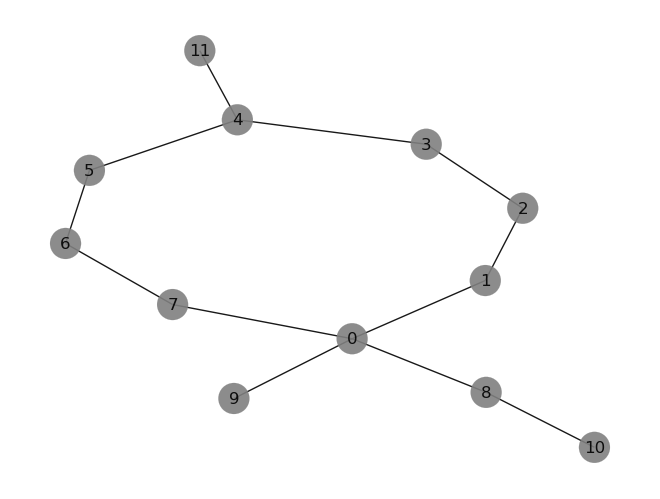

Prediction: [80.5668]
Ground Truth: [80.4]


In [62]:
id = 0
mapped_id = int(test_dataset.processed_files[id].split("_")[-1].split(".")[0])

test_sample_nx = nx.read_gpickle(os.path.join(test_dataset.data_folder, test_dataset.list_graphs[mapped_id]))
draw_graph(test_sample_nx)
plt.show()

test_sample = test_dataset.get(id+1)
# test_sample_nx = to_networkx(test_sample)
# draw_graph(test_sample_nx, color=False)
# plt.show()

pred = model(test_sample.x, test_sample.edge_index, None).detach().cpu().numpy()[0]
truth = test_sample.y.detach().cpu().numpy()
print("Prediction:", pred)
print("Ground Truth:", truth)